# Day 7 - Directed graphs

* https://adventofcode.com/2020/day/7

We are asked about relationships between bags, an [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph)! Because it is _acyclic_ (no bag can contain itself, even indirectly), for the first answer all we have to do is to traverse this graph backward to find all unique bag types that are permitted to contain our **shiny gold** bag, directly or indirectly.

To do this, put all bags *B* that can contain a bag type *C* in a set that you store in a dictionary keyed by *C*. Then use a stack to visit all bags *B* that you haven't seen before, putting those on the stack too, until you run out of bags to check:

In [1]:
from collections import deque
from collections.abc import Iterable, Mapping, Set

ColourCode = str
CanContain = Mapping[ColourCode]
BagRules = Mapping[ColourCode, CanContain]

def parse_rules(lines: Iterable[str]) -> BagRules:
    rules = {}
    for line in lines:
        outer, _, rest = line.partition(" bags contain ")
        can_contain = rules[outer] = {}
        if rest != 'no other bags.':
            for rule in rest.rstrip('.').split(', '):
                count, col1, col2, _ = rule.split()
                can_contain[f"{col1} {col2}"] = int(count)
    return rules

def valid_outer_bag_colors(bag_rules: BagRules, inner_bag: ColourCode = 'shiny gold') -> Set[ColourCode]:
    inverted = {}
    for outer, can_contain in bag_rules.items():
        for inner in can_contain:
            inverted.setdefault(inner, set()).add(outer)

    stack = deque([inner_bag])
    seen = set()
    while stack:
        colour = stack.pop()
        if colour in seen:
            continue
        seen.add(colour)
        stack.extend(inverted.get(colour, ()))

    return seen - {inner_bag}

test = parse_rules("""\
light red bags contain 1 bright white bag, 2 muted yellow bags.
dark orange bags contain 3 bright white bags, 4 muted yellow bags.
bright white bags contain 1 shiny gold bag.
muted yellow bags contain 2 shiny gold bags, 9 faded blue bags.
shiny gold bags contain 1 dark olive bag, 2 vibrant plum bags.
dark olive bags contain 3 faded blue bags, 4 dotted black bags.
vibrant plum bags contain 5 faded blue bags, 6 dotted black bags.
faded blue bags contain no other bags.
dotted black bags contain no other bags.
""".splitlines())

assert len(valid_outer_bag_colors(test)) == 4

In [2]:
import aocd

bag_rules = parse_rules(aocd.get_data(day=7, year=2020).splitlines())

In [3]:
print("Part 1:", len(valid_outer_bag_colors(bag_rules)))

Part 1: 326


## Visualisation

I could not resist trying to visualise these rules, and had a lot of fun with [color theory](https://www.tigercolor.com/color-lab/color-theory/color-theory-intro.htm) and the [HSL color space](https://en.wikipedia.org/wiki/HSL_and_HSV). Did you know the Python standard library has a [`colorsys` module](https://docs.python.org/3/library/colorsys.html) to help map between colour spaces? I didn't!

The puzzle input does become a rather _large_ plot.

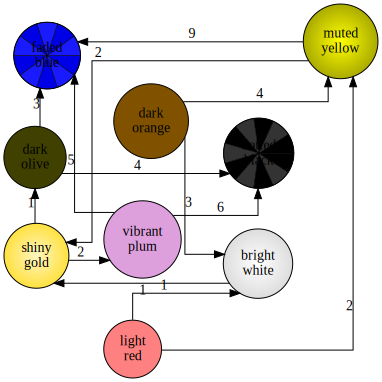

In [4]:
import colorsys
import subprocess
import graphviz
from typing import Any, Callable

from matplotlib import colors

def _hsl_to_hex(h: float, l: float, s: float) -> str:
    return colors.to_hex(colorsys.hls_to_rgb(h, l, s))

def _scale_l(c: str, lscale: float = 0.5) -> str:
    h, l, s = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return _hsl_to_hex(h, l + lscale * (1 - l if lscale > 0 else l), s)

def lighten(c: str, perc: float = 0.5) -> str:
    return _scale_l(c, perc)

def darken(c: str, perc: float = 0.5) -> str:
    return _scale_l(c, -perc)

def comp(c: str) -> str:
    h, l, s = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return _hsl_to_hex((h + 0.5) % 1, l, s)

def mirror(c: str) -> str:
    h, l, s = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return _hsl_to_hex((h + 0.5) % 1, 1 - l, s)

def triadic(c: str) -> tuple[str, str]:
    h, l, s = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return (_hsl_to_hex((h + (1 / 3)) % 1, l, s), _hsl_to_hex((h + (2 / 3)) % 1, l, s))

def splitcomp(c: str) -> tuple[str, str]:
    h, l, s = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return (_hsl_to_hex((h + (5 / 12)) % 1, l, s), _hsl_to_hex((h + (7 / 12)) % 1, l, s))


named = colors.get_named_colors_mapping() | {"bronze": "#CD7F32"}
adjectives: Mapping[str, Callable[[str], tuple[str, str]]] = {
    "light":    lambda c: (lighten(c), "filled"),
    "dark":     lambda c: (darken(c), "filled"),
    "bright":   lambda c: (f"{c};0.95:{darken(c, 0.2)}", "radial"),
    "muted":    lambda c: (f"{c};0.2:{darken(c)}", "radial"),
    "shiny":    lambda c: (f"{lighten(c, 0.75)};0.2:{c}", "radial"),
    "vibrant":  lambda c: (c, "filled"),
    "faded":    lambda c: (f"{c}:{lighten(c, 0.1)};0.1:{darken(c, 0.1)};0.1" * 5, "wedged"),
    "dotted":   lambda c: (f"{c}:{lighten(c, 0.2)}:{darken(c, 0.2)}" * 5, "wedged"),
    "dim":      lambda c: (f"{c};0.4:{darken(c)}", "radial"),
    "drab":     lambda c: (f"{c}:{lighten(c, 0.1)};0.2:{darken(c, 0.1)};0.2" * 6, "wedged"),
    "plaid":    lambda c: (":".join((c, *triadic(c))) * 6, "wedged"),
    "mirrored": lambda c: (f"{c}:{mirror(c)}", "radial"),
    "posh":     lambda c: (":".join((c, *splitcomp(c))) * 2, "wedged"),
    "wavy":     lambda c: (c, "filled"),
    "pale":     lambda c: (c, "filled"),
    "clear":    lambda c: (c, "filled"),
    "striped":  lambda c: (c, "filled"),
    "dull":     lambda c: (c, "filled"),
}

def colorcode_to_dot(code: ColourCode) -> (str, str):
    """Produce fillcolor and style strings from a bag code"""
    adj, col = code.split()
    colour = named[col]
    return adjectives.get(adj, lambda c: (c, "filled"))(colour)


def plot_bag_graph(g: BagRules, **graph_attr: Mapping[str: str]) -> graphviz.Digraph:
    dot = graphviz.Digraph('bag_containment', strict=True, engine="osage")
    dot.attr(**graph_attr)
    dot.attr('node', shape='circle')
    for dep, nodes in sorted(g.items()):
        fill, style = colorcode_to_dot(dep)
        dot.node(dep, dep.replace(" ", "\n"), fillcolor=fill, style=style)
        for node, count in nodes.items():
            fill, style = colorcode_to_dot(node)
            dot.node(node, node.replace(" ", "\n"), fillcolor=fill, style=style)
            dot.edge(dep, node, xlabel=str(count))
    try:
        # attempt to process the graph through cluster, if available
        result = subprocess.run("cluster", input=dot.source, capture_output=True, encoding='utf8')
        if result.returncode == 0:
            dot = graphviz.Source(result.stdout, engine=dot.engine)
    except OSError:
        pass
        
    return dot

plot_bag_graph(test, rankdir='LR', pack="12", packmode="graph", splines="ortho")

In [5]:
plot_bag_graph(bag_rules, size="15,15", pack="12", packmode="graph", splines="polyline")

# Part 2

To add up all the nested bags, traverse in the opposite way, updating the counts of contained bags as you add them to the stack:

In [6]:
def total_bags(bag_rules: BagRules, outer: ColourCode = "shiny gold") -> int:
    stack = deque([{outer: 1}])  # 1 x outer bag
    total = 0
    while stack:
        rules = stack.pop()
        for code, count in rules.items():
            total += count
            stack.append({c: cnt * count for c, cnt in bag_rules[code].items()})
    return total - 1

assert total_bags(test) == 32

test2 = parse_rules("""\
shiny gold bags contain 2 dark red bags.
dark red bags contain 2 dark orange bags.
dark orange bags contain 2 dark yellow bags.
dark yellow bags contain 2 dark green bags.
dark green bags contain 2 dark blue bags.
dark blue bags contain 2 dark violet bags.
dark violet bags contain no other bags.
""".splitlines())
assert total_bags(test2) == 126

In [7]:
print("Part 2:", total_bags(bag_rules))

Part 2: 5635
